In [1]:
import sys; sys.path.insert(0, '..')
import dill as pickle
import numpy as np
import pandas as pd
import itertools
from ldf.best_subset import best_n_avg
from ldf.ldf import ldf
from scipy.stats import norm, multivariate_normal
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

sns.set_style("whitegrid")
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":20,"axes.labelsize":20})
plt.rc('legend',fontsize=16)
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
%matplotlib inline

## All forecasts

In [2]:
## select uip_l1_save file for small model pool and full_save for the large model pool
log_lik = np.load(r"..//data//FX//uip_l1_save_loglik.npz")["x"]

In [3]:
np.log(np.exp(log_lik[:,120:]).mean(axis=0)).mean()

21.708867414884452

In [4]:
np.log(np.exp(log_lik[:,120:]).mean(axis=0)).sum()

5253.545914402037

## LDF

In [5]:
c= 10**(-20)
discount_factors = np.array([1, 0.99, 0.95, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.001]) # np.linspace(0.2, 1.0, 81) # 

### Model averaging

### 2-level LDF(softmax, argmax)

In [6]:
res_ldf = ldf(log_lik.astype(float), levels=2, discount_factors=[discount_factors, discount_factors], activation_functions=["softmax", "argmax"], c=c)
ldfa_df = pd.DataFrame([discount_factors, res_ldf["logscores"][:,-242:].mean(axis=1), res_ldf["logscores"][:,-242:].sum(axis=1)]).T
ldfa_df.style.format("{:.2f}")

,0,1,2
0,1.00,22.04,5334.29
1,0.99,22.07,5340.20
2,0.95,22.09,5346.56
3,0.90,22.11,5351.78
4,0.80,22.14,5358.06
5,0.70,22.13,5355.35
6,0.60,22.14,5358.99
7,0.50,22.14,5358.76
8,0.40,22.15,5359.51
9,0.30,22.11,5349.67


In [7]:
ldf_a = res_ldf["logscores"][:,-242:].cumsum(axis=1)[res_ldf["logscores"][:,:-242].sum(axis=1).argmax(),:]

In [8]:
discount_factors[res_ldf["logscores"][:,:-242].sum(axis=1).argmax()]

0.9

### 2-level LDF(softmax, softmax)

In [9]:
res_ldf = ldf(log_lik.astype(float), levels=2, discount_factors=[discount_factors, discount_factors], activation_functions=["softmax", "softmax"], c=c)
ldfs_df = pd.DataFrame([discount_factors, res_ldf["logscores"][:,-242:].mean(axis=1), res_ldf["logscores"][:,-242:].sum(axis=1)]).T
ldfs_df.style.format("{:.2f}")

,0,1,2
0,1.00,22.04,5334.40
1,0.99,22.08,5342.20
2,0.95,22.13,5355.42
3,0.90,22.16,5362.06
4,0.80,22.15,5359.58
5,0.70,22.13,5354.71
6,0.60,22.11,5350.92
7,0.50,22.10,5348.05
8,0.40,22.09,5345.82
9,0.30,22.08,5344.05


In [10]:
ldf_s = res_ldf["logscores"][:,-242:].cumsum(axis=1)[res_ldf["logscores"][:,:-242].sum(axis=1).argmax(),:]

In [11]:
discount_factors[res_ldf["logscores"][:,:-242].sum(axis=1).argmax()]

0.8

In [12]:
_temp = res_ldf["params_weights"][4][-242:] * discount_factors
_temp.sum(axis=1).mean()

0.7354428147959886

In [13]:
_temp = res_ldf["params_weights"][0][-242:] * discount_factors
_temp.sum(axis=1).mean()

0.7707379136508271

In [14]:
ldf_aa = res_ldf["logscores"][:,-242:].cumsum(axis=1)[res_ldf["logscores"][:,:-242].sum(axis=1).argmax(),:]

In [15]:
discount_factors[res_ldf["logscores"][:,:-242].sum(axis=1).argmax()]

0.8

In [16]:
_temp = res_ldf["params_weights"][3][-242:] * discount_factors
_temp.sum(axis=1).mean()

0.7671814354861971

### 1-level LDF(softmax) (DMA)

In [17]:
res_dma = ldf(log_lik.astype(float), levels=1, discount_factors=[discount_factors], activation_functions=["softmax"], c=c)
res_dma_df = pd.DataFrame([discount_factors, res_dma["logscores"][:,-242:].mean(axis=1), res_dma["logscores"][:,-242:].sum(axis=1)]).T
res_dma_df.style.format("{:.2f}")

,0,1,2
0,1.00,21.82,5280.30
1,0.99,21.87,5293.51
2,0.95,22.04,5334.64
3,0.90,22.11,5350.37
4,0.80,22.08,5344.33
5,0.70,22.01,5326.51
6,0.60,21.94,5308.52
7,0.50,21.88,5294.20
8,0.40,21.83,5282.40
9,0.30,21.79,5272.57


In [18]:
dma_res = res_ldf["logscores"][:,-242:].cumsum(axis=1)[res_dma["logscores"][:,:-242].sum(axis=1).argmax(),:]

In [19]:
discount_factors[res_dma["logscores"][:,:-242].sum(axis=1).argmax()]

0.6

### n-level LDF(softmax, softmax, softmax)

In [20]:
n = 20
discount_fac = [discount_factors] * n
activation_functions = ['softmax'] * n
res_ldf = ldf(log_lik.astype(float), levels=n, discount_factors=discount_fac, activation_functions=activation_functions, c=c)
ldfss_df = pd.DataFrame([discount_factors, res_ldf["logscores"][:,-242:].mean(axis=1), res_ldf["logscores"][:,-242:].sum(axis=1)]).T
ldfss_df.style.format("{:.2f}")

,0,1,2
0,1.00,22.13,5355.43
1,0.99,22.13,5355.43
2,0.95,22.13,5355.43
3,0.90,22.13,5355.43
4,0.80,22.13,5355.43
5,0.70,22.13,5355.43
6,0.60,22.13,5355.43
7,0.50,22.13,5355.43
8,0.40,22.13,5355.43
9,0.30,22.13,5355.43


In [21]:
_temp = res_ldf["params_weights"][0][-242:] * discount_factors
_temp.sum(axis=1).mean()

0.6117499999999262

In [22]:
_temp = res_ldf["params_weights"][0][-242:] * discount_factors
_temp.sum(axis=1).mean()

0.6117499999999262

In [23]:
ldf_ss = res_ldf["logscores"][:,-242:].cumsum(axis=1)[res_ldf["logscores"][:,:-242].sum(axis=1).argmax(),:]

In [24]:
discount_factors[res_ldf["logscores"][:,:-242].sum(axis=1).argmax()]

1.0

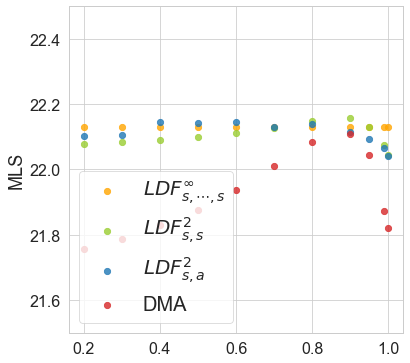

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.scatter(ldfs_df[0].to_list()[:-1], ldfss_df[1].to_list()[:-1], marker='o', color='orange', label="$LDF_{s, \cdots, s}^{\infty}$", s=40, alpha=0.8)
ax.scatter(ldfs_df[0].to_list()[:-1], ldfs_df[1].to_list()[:-1], marker='o', color='yellowgreen', label="$LDF_{s, s}^2$", s=40, alpha=0.8)
ax.scatter(ldfa_df[0].to_list()[:-1], ldfa_df[1].to_list()[:-1], marker='o', color='tab:blue', label="$LDF_{s, a}^2$", s=40, alpha=0.8)
ax.scatter(res_dma_df[0].to_list()[:-1], res_dma_df[1].to_list()[:-1], marker='o', color='tab:red', label="DMA", s=40, alpha=0.8)
ax.set_ylabel(r"MLS")
ax.set_ylim(21.5, 22.5)
ax.legend(loc="lower left");

fig.savefig("fx_small_delta_alpha.pdf")

### N-model average

In [26]:
K = log_lik.shape[0]
n = 4  # size of the team of forecasters to find
rolling_window_length = 20
comb = list(set(itertools.combinations(np.arange(K), n)))
comb = [list(t) for t in comb]

In [27]:
avg_forecasts_loglik = pd.DataFrame(np.asarray([np.log(np.exp(pd.DataFrame(log_lik)).loc[c].mean()) for c in comb]))
max_idx = avg_forecasts_loglik.rolling(rolling_window_length, min_periods=rolling_window_length, axis=1).mean().idxmax()
best_loglik = np.asarray([avg_forecasts_loglik.loc[idx][j] for idx, j in zip(max_idx[-242-1:-1], avg_forecasts_loglik.columns[-242:])])

In [28]:
np.mean(best_loglik)

22.103747085282905

In [29]:
max_idx.tail(20)

342     4566.0
343    18739.0
344    33375.0
345    33375.0
346     9545.0
347     9545.0
348    33375.0
349    33375.0
350    33375.0
351    33375.0
352    33375.0
353    33375.0
354    33375.0
355    18739.0
356    18739.0
357    18739.0
358     5944.0
359     5944.0
360     5944.0
361     5944.0
dtype: float64

### Performance Through time

In [30]:
bar10 = pd.read_csv("barclays_g10.csv", header=0, sep="\t", index_col=0)
bar10.index = pd.to_datetime(bar10.index, format="%d/%m/%Y")
bar10.columns = ["Barclays G10 FX Index"]

In [31]:
from scipy.io import loadmat

deco_obs = loadmat("FX_small_pool2.mat")["mYPred"].mean(axis=3)
fx_cov = loadmat("FX_mYCov2.mat")["mYCov"].mean(axis=3)
fx_real = pd.read_excel("Y.xlsx")
fx_real["Unnamed: 0"] = pd.to_datetime(fx_real["Unnamed: 0"])
fx_real.set_index(["Unnamed: 0"], inplace=True)
real = fx_real.to_numpy()[-361:, :]
ys = deco_obs[-361:, 19, :]
deco_logpdf = np.array([multivariate_normal.logpdf(real[i], ys[i], cov=fx_cov[i]) for i in range(361)])

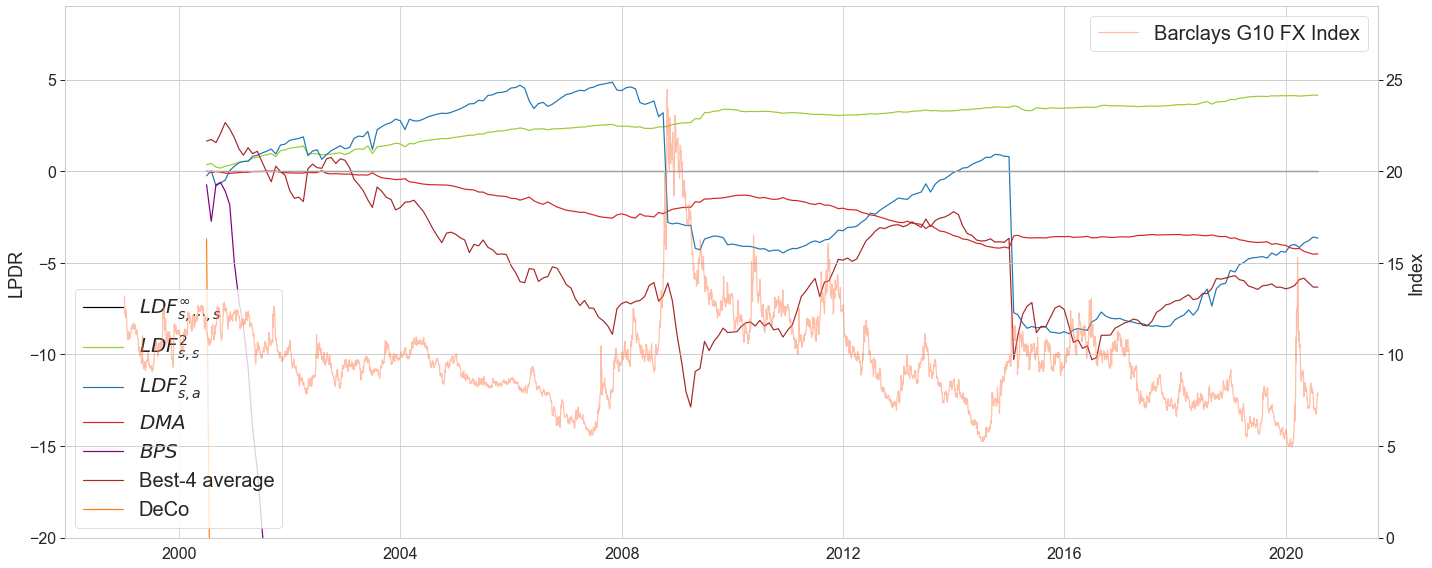

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))
dt_rng = pd.date_range("20000630", "20200731", freq="M")
#ax.plot(dt_rng, ldf_aa-ldf_s, color='magenta', label="$LDF_{a, a}^2$")
ax.plot(dt_rng, ldf_ss-ldf_ss, color='black', label="$LDF_{s,\cdots, s}^{\infty}$")
ax.plot(dt_rng, ldf_s-ldf_ss, color='yellowgreen', label="$LDF_{s, s}^2$")
#ax.plot(dt_rng, ldf_aa-ldf_ss, color='green', label="$LDF_{a, a}^2$")
ax.plot(dt_rng, ldf_a-ldf_ss, color='tab:blue', label="$LDF_{s, a}^2$")
ax.plot(dt_rng, dma_res-ldf_ss, color='tab:red', label="$DMA$")
ax.plot(dt_rng, np.log(bps_lik.mean(axis=1)).cumsum()-ldf_ss, color='purple', label="$BPS$")
ax.plot(dt_rng, best_loglik.cumsum()-ldf_ss, color='brown', label="Best-4 average")
ax.plot(dt_rng, (deco_logpdf[-242:] - ldf_ss).cumsum(), color='tab:orange', label="DeCo")
ax.set_ylabel("LPDR")
ax.set_ylim(-20, 9)
ax.legend(loc="lower left");

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Index')  # we already handled the x-label with ax1
bar10.plot(ax=ax2, color="coral", alpha=0.5)
ax2.tick_params(axis='y')
ax2.set_ylim(0, 29)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

#fig.savefig("fx_lpdr2.pdf")

### Model selection

### 2-level LDF(argmax, argmax)

In [37]:
n = 2
discount_fac = [discount_factors] * n
activation_functions = ['argmax'] * n
res_ldf = ldf(log_lik.astype(float), levels=n, discount_factors=discount_fac, activation_functions=activation_functions, c=c)
ldfa_df = pd.DataFrame([discount_factors, res_ldf["logscores"][:,-242:].mean(axis=1), res_ldf["logscores"][:,-242:].sum(axis=1)]).T
ldfa_df.style.format("{:.2f}")

,0,1,2
0,1.00,22.04,5333.80
1,0.99,22.05,5336.55
2,0.95,22.04,5334.12
3,0.90,22.06,5339.27
4,0.80,22.06,5338.22
5,0.70,22.05,5335.29
6,0.60,22.00,5325.19
7,0.50,22.01,5327.05
8,0.40,21.99,5321.85
9,0.30,21.97,5317.63


In [38]:
ldf_aa = res_ldf["logscores"][:,-242:].cumsum(axis=1)[res_ldf["logscores"][:,:-242].sum(axis=1).argmax(),:]

In [39]:
_temp = res_ldf["params_weights"][4][-242:] * discount_factors
_temp.sum(axis=1).mean()

0.7683677685950413

### 2-level LDF(argmax, softmax)

In [40]:
res_ldf = ldf(log_lik.astype(float), levels=2, discount_factors=[discount_factors, discount_factors], activation_functions=["argmax", "softmax"], c=c)
ldfs_df = pd.DataFrame([discount_factors, res_ldf["logscores"][:,-242:].mean(axis=1), res_ldf["logscores"][:,-242:].sum(axis=1)]).T
ldfs_df.style.format("{:.2f}")

,0,1,2
0,1.00,22.04,5333.80
1,0.99,22.05,5337.18
2,0.95,22.11,5351.02
3,0.90,22.14,5357.23
4,0.80,22.13,5355.84
5,0.70,22.12,5353.05
6,0.60,22.11,5351.13
7,0.50,22.11,5350.09
8,0.40,22.11,5349.56
9,0.30,22.10,5349.29


### 1-level LDF(argmax) (DML)

In [41]:
res_dml = ldf(log_lik.astype(float), levels=1, discount_factors=[discount_factors], activation_functions=["argmax"], c=c)
res_dml_df = pd.DataFrame([discount_factors, res_dml["logscores"][:,-242:].mean(axis=1), res_dml["logscores"][:,-242:].sum(axis=1)]).T
res_dml_df.style.format("{:.2f}")

,0,1,2
0,1.00,21.51,5206.41
1,0.99,21.54,5213.80
2,0.95,21.93,5307.47
3,0.90,21.96,5314.51
4,0.80,22.01,5326.75
5,0.70,22.04,5333.80
6,0.60,22.05,5335.41
7,0.50,22.01,5326.34
8,0.40,21.95,5313.10
9,0.30,21.94,5309.72


In [42]:
ldf_a = res_dml["logscores"][:,-242:].cumsum(axis=1)[res_dml["logscores"][:,:-242].sum(axis=1).argmax(),:]

### n-level LDF(argmax) (DML)

In [43]:
n = 20
discount_fac = [discount_factors] * n
activation_functions = ['argmax'] * n
res_ldf = ldf(log_lik.astype(float), levels=n, discount_factors=discount_fac, activation_functions=activation_functions, c=c)
ldfaa_df = pd.DataFrame([discount_factors, res_ldf["logscores"][:,-242:].mean(axis=1), res_ldf["logscores"][:,-242:].sum(axis=1)]).T
ldfaa_df.style.format("{:.2f}")

,0,1,2
0,1.00,22.07,5341.22
1,0.99,22.07,5341.22
2,0.95,22.07,5341.22
3,0.90,22.07,5341.22
4,0.80,22.07,5341.22
5,0.70,22.07,5341.22
6,0.60,22.07,5341.22
7,0.50,22.07,5341.22
8,0.40,22.07,5341.22
9,0.30,22.07,5341.22


In [44]:
ldf_ainf = res_ldf["logscores"][:,-242:].cumsum(axis=1)[res_ldf["logscores"][:,:-242].sum(axis=1).argmax(),:]

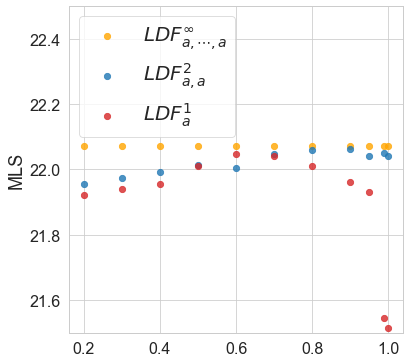

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.scatter(ldfaa_df[0].to_list()[:-1], ldfaa_df[1].to_list()[:-1], marker='o', color='orange', label="$LDF_{a,\cdots, a}^{\infty}$", s=40, alpha=0.8)
#ax.scatter(ldfs_df[0].to_list()[:-1], ldfs_df[1].to_list()[:-1], marker='o', color='yellowgreen', label="$LDF_{a, s}^2$", s=40, alpha=0.8)
ax.scatter(ldfa_df[0].to_list()[:-1], ldfa_df[1].to_list()[:-1], marker='o', color='tab:blue', label="$LDF_{a, a}^2$", s=40, alpha=0.8)
ax.scatter(res_dml_df[0].to_list()[:-1], res_dml_df[1].to_list()[:-1], marker='o', color='tab:red', label="$LDF_{a}^1$", s=40, alpha=0.8)
ax.set_ylabel(r"MLS")
ax.set_ylim(21.5, 22.5)
ax.legend(loc="upper left");
fig.savefig("fx_small_delta_alpha_selection.pdf")

## BPS

In [46]:
bps_lik = np.load(r"..//data//BPS//loglik_fx_5000n.npy") #loglik_fx_5000n _95beta_delta

In [47]:
#bps_lik = np.load(r"..//data//BPS//loglik_fx_5000_20230927_3.npy") #loglik_fx_5000n _95beta_delta

In [48]:
np.log(bps_lik.mean(axis=1)).mean()

21.601505312629726

In [49]:
np.log(bps_lik.mean(axis=1)).sum()

5227.564285656394

In [50]:
np.log(bps_lik.mean(axis=1)).sum()

5227.564285656394

In [51]:
y_ret = pd.read_excel(r"..//data//FX//Y.xlsx")

## 2-level LDF vs BPS for a single currency pair

In [52]:
log_lik = np.load(r"..//data//FX//uip_l1_save_loglik.npz")["x"]
means = np.load(r"..//data//FX//uip_l1_save_means.npz")["x"]
covariance= np.load(r"..//data//FX//uip_l1_save_covariance.npz")["x"]

In [53]:
res_ldf = ldf(log_lik.astype(float), levels=2, discount_factors=[discount_factors, discount_factors], activation_functions=["softmax", "softmax"], c=c)
ldfs_df = pd.DataFrame([discount_factors, res_ldf["logscores"][:,-242:].mean(axis=1), res_ldf["logscores"][:,-242:].sum(axis=1)]).T
ldfs_df.style.format("{:.2f}")

,0,1,2
0,1.00,22.04,5334.40
1,0.99,22.08,5342.20
2,0.95,22.13,5355.42
3,0.90,22.16,5362.06
4,0.80,22.15,5359.58
5,0.70,22.13,5354.71
6,0.60,22.11,5350.92
7,0.50,22.10,5348.05
8,0.40,22.09,5345.82
9,0.30,22.08,5344.05


#### Calculate mean prediction for gaussian mixture and the quantiles

In [54]:
# Return the smallest value x between lo and hi such that f(x) >= v
def continuous_bisect_fun_left(f, v, lo, hi):
    val_range = [lo, hi]
    k = 0.5 * sum(val_range)
    for i in range(32):
        val_range[int(f(k) > v)] = k
        next_k = 0.5 * sum(val_range)
        if next_k == k:
            break
        k = next_k
    return k

def get_mixture_cdf(component_distributions, ps):
    return lambda x: sum(component_dist.cdf(x) * p for component_dist, p in zip(component_distributions, ps))

# Return the pth quantile of the mixture distribution given by the component distributions and their probabilities
def mixture_quantile(p, component_distributions, ps):
    mixture_cdf = get_mixture_cdf(component_distributions, ps)

    # We can probably be a bit smarter about how we pick the limits
    lo = np.min([dist.ppf(p) for dist in component_distributions])
    hi = np.max([dist.ppf(p) for dist in component_distributions])

    return continuous_bisect_fun_left(mixture_cdf, p, lo, hi)

In [55]:
weights = res_ldf["weights"][3, -242:, :]

In [56]:
component_distributions = []
for i in range(weights.shape[0]):
    component_distributions.append([norm(loc=means[j, 120+i, -1], scale=np.sqrt(covariance[j, 120+i, -1, -1])) for j in range(weights.shape[1])])

In [57]:
qs = []
for i in range(weights.shape[0]):
    qs.append([mixture_quantile(0.05, component_distributions[i], weights[i,:]), mixture_quantile(0.95, component_distributions[i], weights[i,:])])
qs = np.asarray(qs)

In [58]:
ldf_s_s_2_pred = (means[:, -242:, -1] * weights.T).sum(axis=0)

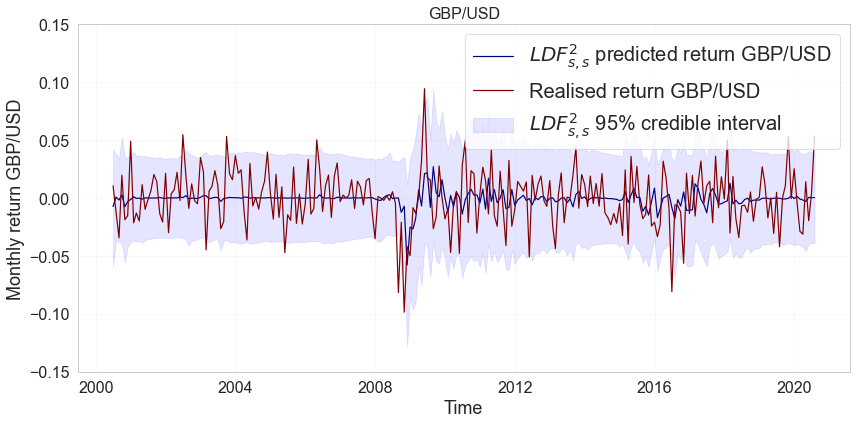

In [59]:
ccy = "GBP"
ccy_idx = 8
pair = f'{ccy}/USD'
time = y_ret["Unnamed: 0"][126:]
burnin = 127
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(time, ldf_s_s_2_pred, c='navy', label=r'$LDF_{s,s}^2$ predicted return ' + f"{pair}")
ax.plot(time, y_ret["GBP"][126:], c='maroon', label=f'Realised return {pair}')
ax.fill_between(time, qs[:,0], qs[:,1], 
                color='blue', alpha=0.1, label='$LDF_{s,s}^2$ 95% credible interval')

ax.set_ylim(-0.15, 0.15)
ax.set_title(f'{pair}')
ax.legend(loc='upper right')
ax.set_xlabel('Time')
ax.set_ylabel(f'Monthly return {pair}')
ax.grid(alpha=0.2, which='major', c='lightgrey')
fig.tight_layout() 
plt.show()